In [36]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the IRS website
irs_url = "https://www.irs.gov/pub/irs-soi/22zpallagi.csv"
df_irs = pd.read_csv(irs_url, encoding="ISO-8859-1", low_memory=False)
df_irs["Population"] = df_irs[["mars1", "MARS2", "MARS4"]].sum(axis=1, skipna=True)
# Save it as a local CSV file
df_irs.to_csv("22zpallagi.csv", index=False)

print("IRS data downloaded and saved as '22zpallagi.csv'")
df_irs.head()

IRS data downloaded and saved as '22zpallagi.csv'


,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,Population
0,1,AL,0,1,659530.0,422590.0,71000.0,154700.0,610780.0,24340.0,...,0.0,63060.0,54280.0,543620.0,1559881.0,541480.0,1552563.0,2250.0,5031.0,648290.0
1,1,AL,0,2,533640.0,276250.0,101050.0,141040.0,499310.0,15050.0,...,0.0,100320.0,130848.0,430380.0,1339883.0,427830.0,1329439.0,2780.0,8556.0,518340.0
2,1,AL,0,3,304870.0,134050.0,109980.0,51600.0,286110.0,9600.0,...,0.0,88750.0,186002.0,216080.0,585162.0,212990.0,573080.0,4520.0,12589.0,295630.0
3,1,AL,0,4,193020.0,56350.0,113100.0,19090.0,181390.0,4530.0,...,0.0,67040.0,189833.0,124860.0,403052.0,121760.0,388581.0,2840.0,12190.0,188540.0
4,1,AL,0,5,315700.0,45000.0,252660.0,12180.0,297930.0,9000.0,...,63.0,138270.0,657283.0,177730.0,748507.0,169080.0,671684.0,10940.0,80141.0,309840.0


## census

In [5]:
API_KEY = "b4434bb9b6ae23472c5dfcf04177f38065b58b02"

url = "https://api.census.gov/data/2022/acs/acs5/profile"
params = {
    "get": "DP05_0001E,DP03_0062E,DP02_0067PE",  # total pop, median income, % bachelor's
    "for": "zip code tabulation area:*",
    "key": API_KEY
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    df1 = pd.DataFrame(data[1:], columns=data[0])
    df1 = df1.rename(columns={
        "DP05_0001E": "Total_Population",
        "DP03_0062E": "Median_Income",
        "DP02_0067PE": "Percent_Bachelor_or_Higher",
        "zip code tabulation area": "ZIP"
    })
    df1.to_csv("census_data.csv", index=False)
    print("Saved as census_data.csv")
else:
    print("API request failed")
df1.head()

Saved as census_data.csv


,Total_Population,Median_Income,Percent_Bachelor_or_Higher,ZIP
0,16834,17526,None,00601
1,37642,20260,None,00602
2,49075,17703,None,00603
3,5590,19603,None,00606
4,25542,22796,None,00610


### Business Patterns

In [6]:
# Reading with Latin-1 encoding (works for most Census files)
df3 = pd.read_csv("zbp21detail.txt", delimiter=",", encoding='latin1', dtype=str)

# Show the columns and sample rows
print("Columns:", df3.columns.tolist())
print(df3.head())


Columns: ['zip', 'name', 'naics', 'est', 'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499', 'n500_999', 'n1000', 'city', 'stabbr', 'cty_name']
     zip            name   naics est n<5 n5_9 n10_19 n20_49 n50_99 n100_249  \
0  00501  HOLTSVILLE, NY  ------  10   8    N      N      N      N        N   
1  00501  HOLTSVILLE, NY  81----   5   3    N      N      N      N        N   
2  00501  HOLTSVILLE, NY  813///   3   N    N      N      N      N        N   
3  00501  HOLTSVILLE, NY  8131//   3   N    N      N      N      N        N   
4  00501  HOLTSVILLE, NY  81311/   3   N    N      N      N      N        N   

  n250_499 n500_999 n1000        city stabbr cty_name  
0        N        N     N  HOLTSVILLE     NY  SUFFOLK  
1        N        N     N  HOLTSVILLE     NY  SUFFOLK  
2        N        N     N  HOLTSVILLE     NY  SUFFOLK  
3        N        N     N  HOLTSVILLE     NY  SUFFOLK  
4        N        N     N  HOLTSVILLE     NY  SUFFOLK  


### Load & Prepare IRS Data

In [7]:
df_irs = pd.read_csv("22zpallagi.csv", encoding="ISO-8859-1", low_memory=False)
df_irs['ZIP'] = df_irs['zipcode'].astype(str).str.zfill(5)
df_irs_clean = df_irs[['ZIP', 'STATE', 'A00100']]  # A00100 = total AGI


### Census Data

In [8]:
df_census = pd.read_csv("census_data.csv")
df_census['ZIP'] = df_census['ZIP'].astype(str).str.zfill(5)

### Business 

In [9]:
df_zbp_raw = pd.read_csv("zbp21detail.txt", delimiter=",", encoding='latin1', dtype=str)
df_zbp_raw['ZIP'] = df_zbp_raw['zip'].astype(str).str.zfill(5)
df_zbp_raw['est'] = pd.to_numeric(df_zbp_raw['est'], errors='coerce')
#  Aggregate business counts per ZIP
df_zbp = df_zbp_raw.groupby('ZIP')['est'].sum().reset_index()
df_zbp.columns = ['ZIP', 'Total_Businesses']

Merge Datasets by ZIP

In [10]:
df_merged = df_irs_clean.merge(df_census, on='ZIP', how='inner')

# Merge Business data
df_merged = df_merged.merge(df_zbp, on='ZIP', how='inner')
df_merged = df_merged.rename(columns={"A00100": "Total_AGI"})


### Data cleaning steps

In [11]:

df_clean = df_merged.dropna()
df_clean = df_clean[(df_clean['Total_AGI'] > 0) & (df_clean['Total_Population'] > 0)]

# Ensure ZIP codes are 5-digit strings (standard format)
df_clean['ZIP'] = df_clean['ZIP'].astype(str).str.zfill(5)
   
# Convert numeric fields to correct types (if not already)
numeric_cols = ['Total_AGI', 'Total_Population', 'Median_Income',
                'Percent_Bachelor_or_Higher', 'Total_Businesses']
df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Remove any rows that became NaN during numeric conversion
df_clean = df_clean.dropna(subset=numeric_cols)
df_clean['AGI_Per_Capita'] = df_clean['Total_AGI'] / df_clean['Total_Population']
df_clean['Business_Density'] = df_clean['Total_Businesses'] / (df_clean['Total_Population'] / 1000)
df_clean['AGI_Level'] = pd.qcut(df_clean['Total_AGI'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])




In [12]:
df_clean.head()

,ZIP,STATE,Total_AGI,Total_Population,Median_Income,Percent_Bachelor_or_Higher,Total_Businesses,AGI_Per_Capita,Business_Density,AGI_Level
0,35004,AL,15888.0,11737,76683,94.0,853,1.353668,72.676152,Mid-Low
1,35004,AL,49413.0,11737,76683,94.0,853,4.210020,72.676152,Mid-High
2,35004,AL,61695.0,11737,76683,94.0,853,5.256454,72.676152,Mid-High
3,35004,AL,53252.0,11737,76683,94.0,853,4.537105,72.676152,Mid-High
4,35004,AL,139477.0,11737,76683,94.0,853,11.883531,72.676152,High


In [13]:
df_clean.columns

Index(['ZIP', 'STATE', 'Total_AGI', 'Total_Population', 'Median_Income',
       'Percent_Bachelor_or_Higher', 'Total_Businesses', 'AGI_Per_Capita',
       'Business_Density', 'AGI_Level'],
      dtype='object')

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153918 entries, 0 to 162598
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   ZIP                         153918 non-null  object  
 1   STATE                       153918 non-null  object  
 2   Total_AGI                   153918 non-null  float64 
 3   Total_Population            153918 non-null  int64   
 4   Median_Income               153918 non-null  int64   
 5   Percent_Bachelor_or_Higher  153918 non-null  float64 
 6   Total_Businesses            153918 non-null  int64   
 7   AGI_Per_Capita              153918 non-null  float64 
 8   Business_Density            153918 non-null  float64 
 9   AGI_Level                   153918 non-null  category
dtypes: category(1), float64(4), int64(3), object(2)
memory usage: 11.9+ MB


In [15]:
df_clean.describe()

,Total_AGI,Total_Population,Median_Income,Percent_Bachelor_or_Higher,Total_Businesses,AGI_Per_Capita,Business_Density
count,1.539180e+05,153918.000000,1.539180e+05,1.539180e+05,153918.000000,153918.000000,153918.000000
mean,9.399191e+04,12704.972128,-8.874208e+06,-4.241723e+03,1605.752894,7.316743,103.826510
std,3.036139e+05,15938.040526,7.672647e+07,1.699277e+06,2606.147909,18.668080,285.912733
min,1.970000e+02,5.000000,-6.666667e+08,-6.666667e+08,3.000000,0.078189,0.685244
25%,7.104250e+03,1625.000000,5.478700e+04,8.630000e+01,63.000000,2.911161,35.805627
50%,2.254600e+04,5255.000000,6.831750e+04,9.140000e+01,380.000000,4.379382,70.771656
75%,8.192075e+04,19002.000000,8.699400e+04,9.500000e+01,2138.000000,6.561398,119.659819
max,1.934949e+07,134008.000000,2.500010e+05,1.000000e+02,39282.000000,2213.972222,21757.630162


In [16]:
df_clean.isna().sum()

ZIP                           0
STATE                         0
Total_AGI                     0
Total_Population              0
Median_Income                 0
Percent_Bachelor_or_Higher    0
Total_Businesses              0
AGI_Per_Capita                0
Business_Density              0
AGI_Level                     0
dtype: int64

In [37]:
df_clean.to_csv("cleaned_data.csv", index=False)

### Plot top 10 states by total income

In [33]:
import plotly.express as px

# Prepare top 10 states by Total AGI
top_states = df_clean.groupby('STATE')['Total_AGI'].sum().sort_values(ascending=False).head(10).reset_index()

# Create interactive bar chart
fig = px.bar(
    top_states,
    x='STATE',
    y='Total_AGI',
    text='Total_AGI',
    color='STATE',  # Discrete colors
    color_discrete_sequence=px.colors.qualitative.Set2,  # Choose any from Plotly's qualitative palettes
    title='Top 10 States by Total Adjusted Gross Income (AGI)',
    labels={'Total_AGI': 'Total Income', 'STATE': 'State'},
)

# Format text on bars
fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside')

# Improve layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Total AGI',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    plot_bgcolor='white',
)

fig.show()


### Top Population States

c:\Users\My PC\Bus\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.



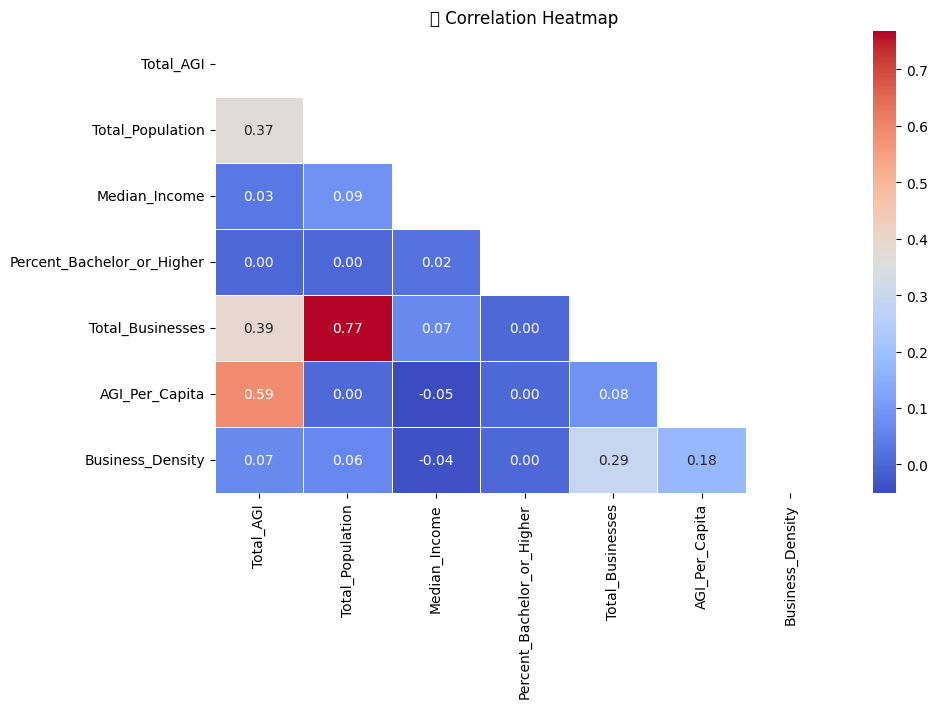

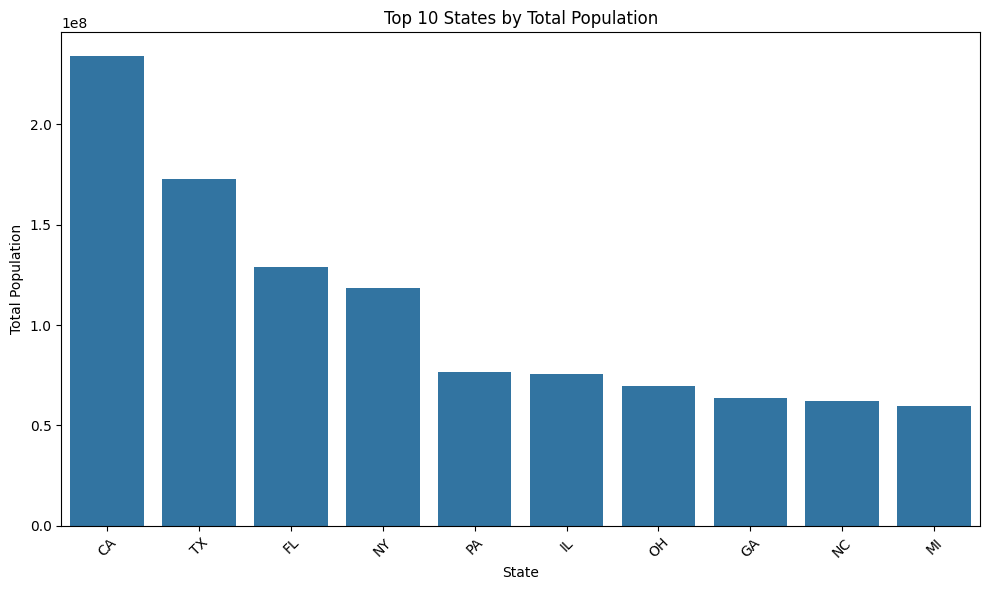

In [34]:
# Group data
top_population_states = df_clean.groupby('STATE')['Total_Population'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_population_states.index, y=top_population_states.values)

plt.title('Top 10 States by Total Population')
plt.xlabel('State')
plt.ylabel('Total Population')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🔍 Correlation with Total_AGI:
 Total_AGI                     1.000000
AGI_Per_Capita                0.585635
Total_Businesses              0.392288
Total_Population              0.367627
Business_Density              0.070067
Median_Income                 0.034375
Percent_Bachelor_or_Higher    0.000771
Name: Total_AGI, dtype: float64


C:\Users\My PC\AppData\Local\Temp\ipykernel_18916\3655328736.py:23: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.

c:\Users\My PC\Bus\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.



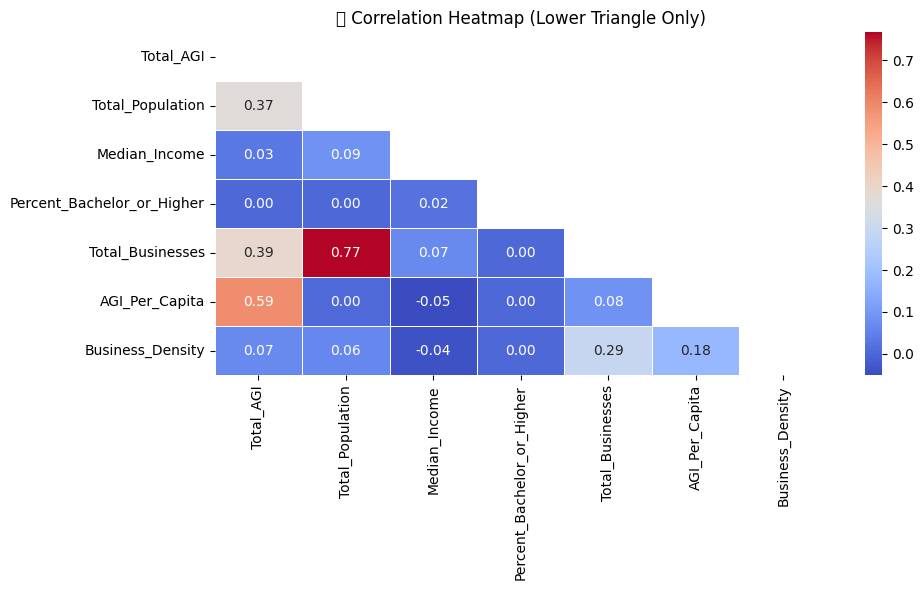

In [35]:
# Sort correlation matrix by correlation with Total_AGI
sorted_corr = corr_matrix['Total_AGI'].sort_values(ascending=False)
print("🔍 Correlation with Total_AGI:\n", sorted_corr)
import plotly.express as px
import pandas as pd

# Melt the correlation matrix for Plotly
corr_melted = corr_matrix.reset_index().melt(id_vars='index')
corr_melted.columns = ['Feature 1', 'Feature 2', 'Correlation']

fig = px.imshow(corr_matrix,
                text_auto='.2f',
                aspect='auto',
                color_continuous_scale='RdBu_r',
                title="Interactive Correlation Heatmap")

fig.show()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # upper triangle mask

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("🔗 Correlation Heatmap (Lower Triangle Only)")
plt.tight_layout()
plt.show()



In [32]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your preprocessed data


st.title("📊 Correlation Heatmap: Economic & Demographic Features")

# Sidebar: Select columns
numeric_cols = ['Total_AGI', 'Total_Population', 'Median_Income',
                'Percent_Bachelor_or_Higher', 'Total_Businesses',
                'AGI_Per_Capita', 'Business_Density']

selected_cols = st.multiselect(
    "Select features to include in the correlation heatmap:",
    numeric_cols,
    default=numeric_cols
)

# If at least two features selected
if len(selected_cols) >= 2:
    # Compute correlation
    corr_matrix = df_clean[selected_cols].corr()

    # Mask for upper triangle (optional)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot with seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=ax)
    ax.set_title("🔗 Correlation Heatmap")
    st.pyplot(fig)
else:
    st.warning("Please select at least 2 features.")


2025-04-19 11:58:09.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 11:58:09.439 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar